In [70]:
import pandas as pd
import glob
pd.options.mode.chained_assignment = None 
import datetime
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
% matplotlib inline

def hello(hi):
    return print(hi)
# PATHS

#Den Bosch flow
path = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150/RG8150/"
path1 = "../data/waterschap-aa-en-maas_sewage_2019_db_pumps/sewer_data_db/data_wwtp_flow/RG1876_flow/"
path2 = "../data/waterschap-aa-en-maas_sewage_2019_db_pumps/sewer_data_db/data_wwtp_flow/RG1882_flow/"


#Bokhoven level
path3 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8180_L0/"
#Bokhoven flow
path4 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8180_Q0/"


#Haarsteeg level
path5 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/rg8170_N99/"
#Haarsteeg flow
path6 = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/rg8170_99/"


#Helftheuvelweg level column 003 Helftheuvelweg *.csv
path7 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Helftheuvelweg flow 
path8 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT301_99/"


#Engelerschans level column “004 Engelerschans” *.csv
path9 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Engelerschans flow + Haarsteeg + Bokhoven, therefore substract for only Engeleschans
path10 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT201_99/"


#Maaspoort level Column: “006 Maaspoort” *.csv 
path11 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Maasport flow + Rompert
path12= "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT501_99/"


#Oude Engelenseweg level Column: “002 Oude Engelenseweg” *.csv
path13 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#Oude Engelenseweg flow
path14 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT401_94/"


#De Rompert level Column: “005 de Rompert” *.csv
path15 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_level/"
#De Rompert flow + Maasport
path16 = "../data/waterschap-aa-en-maas_sewage_2019_db/sewer_data_db/data_pump_flow/1210FIT501_99/"

#Location linkage
path_linkinfo = "../data/waterschap-aa-en-maas_sewage_2019/sewer_model"
path_rain = "../data/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries"

#Missing Engelerschans (in map also)
station_names = ["Haarsteeg", "Bokhoven", "Hertogenbosch (Helftheuvelweg)",
                 "Hertogenbosch (Rompert)", "Hertogenbosch (Oude Engelenseweg)",
                 "Hertogenbosch (Maasport)"]

link = pd.read_csv(path_linkinfo+
                   "/20180717_dump riodat rioleringsdeelgebieden_matched_to_rainfall_locations.csv",
                   header = 9)

rain = pd.concat([pd.read_csv(file, header = 2) for file in glob.glob(path_rain+"/*.*")], ignore_index = True)

def streets_rain(station_names, link, rain_df):
    
    #Street names by stations
    streets = [list(link[(link["Naam kern"] == name)]["Naam / lokatie"]) for name in station_names]

    #Streets that are not found in rainfall data belonging to Hertogenbosch (Oude Engelenseweg)
    excl = ['Pettelaarpark', 'Geb. 16 Paleiskwartier']

    for s in streets:
        try:
            for i in excl:
                s.remove(i)
        except ValueError:
            pass


    #All the rain for the streets for the pump stations in order of station_names and the streets per station
    #can be found in streets nested list in the same order
    station_to_rain = rain[["Begin", "Eind"] + [i for sl in streets for i in sl]]

    station_rain = pd.DataFrame()
    for i in range(len(station_names)):
        station_rain[station_names[i]] = rain[streets[i]].sum(1)

    station_rain["Begin"] =  station_to_rain["Begin"]
    station_rain["End"] = station_to_rain["Eind"]
    station_rain["Begin"] = pd.to_datetime(station_rain["Begin"])
    station_rain["date"] = station_rain["Begin"].dt.date
    return station_rain

#df = streets_rain(station_names, link, rain)

UsageError: Line magic function `%` not found.


In [5]:
# The sum of the rain at all locations per day
#df_dailysum = df.groupby('date').sum()

In [6]:
# Should be revalued
def condition_days(rain_value):
    
    #conditions are made based on wikipedia numbers, intensity section
    #https://en.wikipedia.org/wiki/Rain
    if rain_value == 0:         
        return "No"
    elif 0 < rain_value <= 2.352 :
        return 'Light'
    elif 2.352 < rain_value <= 7.2:
        return 'Moderate'
    elif 7.2 < rain_value <= 48:
        return 'Heavy'
    elif 48 < rain_value:
        return 'Violent'
    else:
        return 'Something went wrong'

    
def class_of_rain(names_list, df_day):
    
    #Adding a column for the type of (rainy) day
    for i in names_list:
        df_day["Rain measure " + i] = df_day.apply(lambda x: condition_days(x[i]), axis=1)
    return df_day   

#classes_rain = class_of_rain(station_names, df_dailysum)

In [14]:
#Applying the same label, but for 5 minute interval data
def instr(day, dictio):
    return dictio[day]

def class_rain_5min(names_list, df_5min, df_day):
    for i in names_list:
        dictio = df_day.to_dict()["Rain measure " + i]
        df_5min["Rain measure " + i] = df_5min.apply(lambda x: instr(x["date"], dictio), axis = 1)
    return df_5min

#classes_rain2 = class_rain_5min(station_names, df, df_dailysum)

In [60]:
#Flow Data
flow_haarsteeg = pd.concat([pd.read_csv(file) for file in glob.glob(path6+"/*.*")], ignore_index = True)

def bound_dates(df1, df2, df1_datecol, df2_datecol):
    
    # Making sure both have the same range of dates
    df1[df1_datecol] = pd.to_datetime(df1[df1_datecol])
    df2[df2_datecol] = pd.to_datetime(df2[df2_datecol])
    d1 = pd.merge(left=df1, left_on=df1_datecol,
         right=df2, right_on=df2_datecol)
    d2 = pd.merge(left=df2, left_on=df2_datecol,
         right=df1, right_on=df1_datecol)
    
    return d1, d2

#classes_rain2, flow_haarsteeg, = bound_dates(classes_rain2, flow_haarsteeg, "Begin", "datumBeginMeting")


In [66]:
#Haarsteeg = classes_rain2[["Haarsteeg", "Begin", "Rain measure Haarsteeg"]]
#no_rain = set(Haarsteeg[Haarsteeg["Rain measure Haarsteeg"] == "No"]["Begin"].dt.date)
#flow_filtered = flow_haarsteeg[flow_haarsteeg["datumBeginMeting"].dt.date.isin(no_rain)]

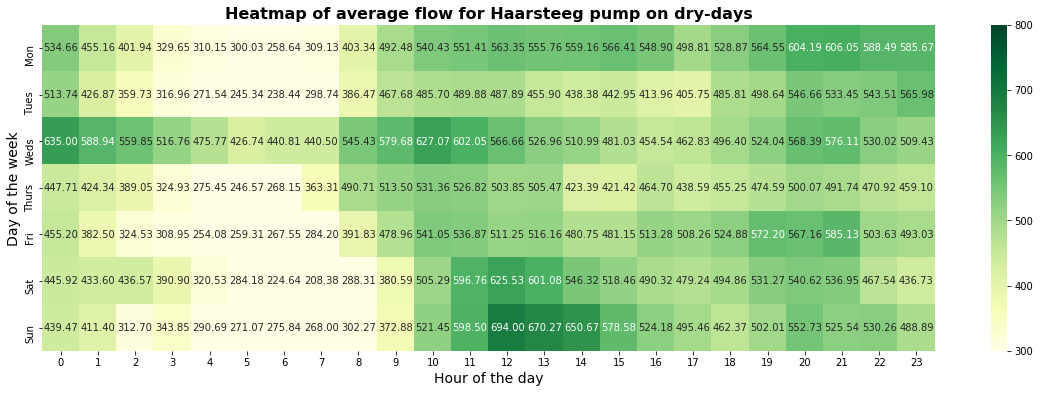

In [76]:
#HEATMAPS DRY next to WET days
# heatdf = flow_filtered[["hstWaarde", "datumBeginMeting"]]
# z = heatdf.groupby([heatdf["datumBeginMeting"].dt.weekday, heatdf["datumBeginMeting"].dt.hour]).describe()
# z = z["hstWaarde"]["mean"]
# z.index.names = ["created_at_day", "created_at_hour"]
# z.columns = ["tweet_conv_size", "tweet_mean_conv"]
# z = z.unstack().reset_index(drop=False)
# days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
# z['created_at_day'] = z['created_at_day'].apply(lambda x: days[x])
# z = z.set_index("created_at_day")
# plt.subplots(figsize=(20, 6))
# fig = sns.heatmap(z, annot=True, fmt=".2f", cmap = "YlGn", vmin= 300,
#                   vmax = 800)
# fig.set_title("Heatmap of average flow for Haarsteeg pump on dry-days", size = 16, weight = "bold");
# fig.set_xlabel("Hour of the day", size = 14);
# fig.set_ylabel("Day of the week", size = 14);

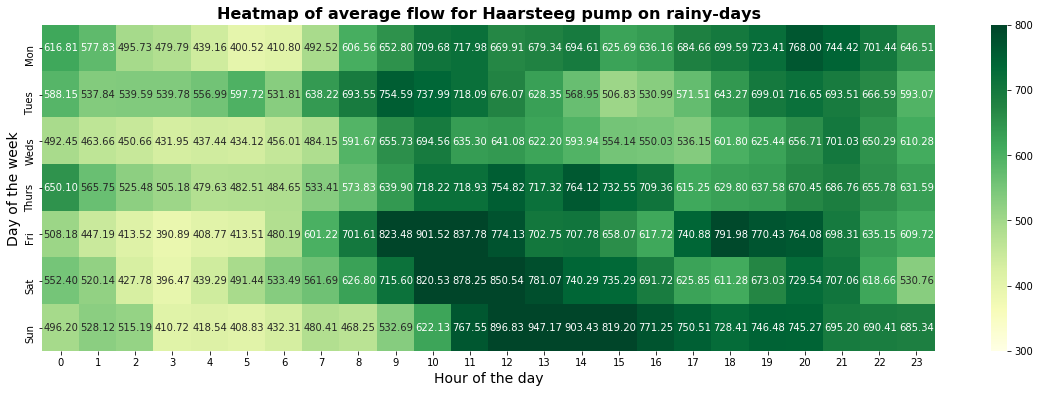

In [77]:
#All kinds of rain
# all_kinds_rain = set(Haarsteeg[Haarsteeg["Rain measure Haarsteeg"] != "No"]["Begin"].dt.date)
# flow_filtered2 = flow[flow["datumBeginMeting"].dt.date.isin(all_kinds_rain)]
# heatdf2 = flow_filtered2[["hstWaarde", "datumBeginMeting"]]
# z = heatdf2.groupby([heatdf2["datumBeginMeting"].dt.weekday, heatdf2["datumBeginMeting"].dt.hour]).describe()
# z = z["hstWaarde"]["mean"]
# z.index.names = ["created_at_day", "created_at_hour"]
# z.columns = ["tweet_conv_size", "tweet_mean_conv"]
# z = z.unstack().reset_index(drop=False)
# days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
# z['created_at_day'] = z['created_at_day'].apply(lambda x: days[x])
# z = z.set_index("created_at_day")
# plt.subplots(figsize=(20, 6))
# fig = sns.heatmap(z, annot=True, fmt=".2f", cmap = "YlGn", vmin= 300,
#                   vmax = 800)
# fig.set_title("Heatmap of average flow for Haarsteeg pump on rainy-days", size = 16, weight = "bold");
# fig.set_xlabel("Hour of the day", size = 14);
# fig.set_ylabel("Day of the week", size = 14);

In [ ]:
# def method_bisect(a,b,c):
#     b.sort()
#     for i,x in enumerate(a):
#         index = bisect.bisect_left(b,x)
#         if index < len(a):
#             if x == b[index]:
#                 c[i] = 1
#     return(time.time()-start_time)